In [43]:
from core.NeuralNet.MLP import MLP
from core.experiments.utils import (save_experiment_results_to_file, evaluate_model)
from core.experiments.ContextClasses import (DataContext, TrainingContext)
from core.experiments.binary_classification.binary_classification_experiment import (
    BinaryClassificationExperiment,
)
from config.config import (
    TRIPLES_PATH,
    ENTITIES_LABELS_PATH,
    PROPERTIES_LABELS_PATH,
    GRAPH_EMBEDDINGS_PATH,
)
from core.NeuralNet.GNN import GCN
from loguru import logger
import sys
import torch
# For Multi class type classification
from core.ToTorch.DataBuilder import NodeTypeDataBuilder
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,MessagePassing

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import matplotlib.pyplot as plt
import os
from config.config import EXPERIMENT_RESULTS_PATH
import datetime

## Multi class classification

In [2]:
#databuilder
data_builder = NodeTypeDataBuilder(
    triples_path=TRIPLES_PATH,
    entities_labels_path=ENTITIES_LABELS_PATH,
    properties_labels_path=PROPERTIES_LABELS_PATH,
    embeddings_path=GRAPH_EMBEDDINGS_PATH,
    labeler=None,
)
data_builder

In [3]:
x = data_builder.get_x()
edge_index = data_builder.get_edge_index()
y = data_builder.get_y()
train_mask, val_mask, test_mask = data_builder.get_entities_masks()

data = Data(
    x=x,
    edge_index=edge_index,
    y=y,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)


In [4]:
data

Data(x=[29025, 768], edge_index=[2, 145402], y=[29025], train_mask=[29025], val_mask=[29025], test_mask=[29025])

In [19]:
class GCN_test(torch.nn.Module):
    def __init__(self, num_node_features, dim_hidden_layer,num_layers, num_classes):
        super().__init__()
        #self.conv1 = GCNConv(num_node_features, dim_hidden_layer)
        #self.conv2 = GCNConv(dim_hidden_layer, num_classes)
        layers = []
        input_dim, output_dim = num_node_features, dim_hidden_layer

        for _ in range(num_layers-1):
            layers = layers+[GCNConv(in_channels=input_dim,out_channels=output_dim),torch.nn.ReLU(),torch.nn.Dropout(p=0.2)]
            
            input_dim = dim_hidden_layer
        layers = layers+[GCNConv(in_channels=input_dim,out_channels=num_classes)]
        self.layers = torch.nn.ModuleList(layers)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        embeddings = []
        for layer in self.layers:
            if isinstance(layer,MessagePassing):
                x = layer(x,edge_index)
                embeddings.append(x.clone())
            else:
                x=layer(x)
            
        return F.log_softmax(x, dim=1), embeddings

In [35]:
NUM_EPOCHS = 1000

In [48]:
# TRAIN MLP
logger.info("Training MLP")
mlp_model = MLP(
    num_node_features=data.num_node_features, dim_hidden_layer=16, num_classes=len(set(data.y.tolist()))
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
mlp_model.train()

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    out = mlp_model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch%100==0:
        logger.debug(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

2023-08-09 18:14:34.211 | INFO     | __main__:<module>:2 - Training MLP
2023-08-09 18:14:34.289 | DEBUG    | __main__:<module>:16 - Epoch: 000, Loss: 4.6414
2023-08-09 18:14:45.291 | DEBUG    | __main__:<module>:16 - Epoch: 100, Loss: 4.6413
2023-08-09 18:14:55.083 | DEBUG    | __main__:<module>:16 - Epoch: 200, Loss: 4.6414
2023-08-09 18:15:04.435 | DEBUG    | __main__:<module>:16 - Epoch: 300, Loss: 4.6413
2023-08-09 18:15:11.587 | DEBUG    | __main__:<module>:16 - Epoch: 400, Loss: 4.6412
2023-08-09 18:15:18.640 | DEBUG    | __main__:<module>:16 - Epoch: 500, Loss: 4.6413
2023-08-09 18:15:25.921 | DEBUG    | __main__:<module>:16 - Epoch: 600, Loss: 4.6413
2023-08-09 18:15:32.899 | DEBUG    | __main__:<module>:16 - Epoch: 700, Loss: 4.6413
2023-08-09 18:15:39.658 | DEBUG    | __main__:<module>:16 - Epoch: 800, Loss: 4.6412
2023-08-09 18:15:47.068 | DEBUG    | __main__:<module>:16 - Epoch: 900, Loss: 4.6413


In [49]:
mlp_model.eval()
pred = mlp_model(data).argmax(dim=1)
correct_predictions_mask = pred[data.test_mask] == data.y[data.test_mask]
incorrect_predictions_mask = pred[data.test_mask] != data.y[data.test_mask]
accuracy = sum(correct_predictions_mask)/len(correct_predictions_mask)
print("MLP accuracy",'{:.2%}'.format(accuracy.item()))

MLP accuracy 0.00%


In [36]:
# TRAIN GNN
logger.info("Training GNN")
model = GCN_test(
    num_node_features=data.num_node_features, dim_hidden_layer=256,num_layers=3, num_classes=len(set(data.y.tolist()))
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    out,embedding = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch%100==0:
        logger.debug(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

2023-08-09 16:57:12.717 | INFO     | __main__:<module>:2 - Training GNN


2023-08-09 16:57:14.414 | DEBUG    | __main__:<module>:16 - Epoch: 000, Loss: 4.5762
2023-08-09 16:59:09.438 | DEBUG    | __main__:<module>:16 - Epoch: 100, Loss: 1.3405
2023-08-09 17:01:01.561 | DEBUG    | __main__:<module>:16 - Epoch: 200, Loss: 1.0208
2023-08-09 17:02:54.483 | DEBUG    | __main__:<module>:16 - Epoch: 300, Loss: 0.8089
2023-08-09 17:05:03.371 | DEBUG    | __main__:<module>:16 - Epoch: 400, Loss: 0.7945
2023-08-09 17:06:55.135 | DEBUG    | __main__:<module>:16 - Epoch: 500, Loss: 0.6668
2023-08-09 17:08:50.845 | DEBUG    | __main__:<module>:16 - Epoch: 600, Loss: 0.6291
2023-08-09 17:10:57.817 | DEBUG    | __main__:<module>:16 - Epoch: 700, Loss: 0.6805
2023-08-09 17:12:44.379 | DEBUG    | __main__:<module>:16 - Epoch: 800, Loss: 0.6035
2023-08-09 17:14:30.061 | DEBUG    | __main__:<module>:16 - Epoch: 900, Loss: 0.6086


In [40]:
model.eval()
pred_,_ = model(data)
pred = pred_.argmax(dim=1)
correct_predictions_mask = pred[data.test_mask] == data.y[data.test_mask]
incorrect_predictions_mask = pred[data.test_mask] != data.y[data.test_mask]
accuracy = sum(correct_predictions_mask)/len(correct_predictions_mask)
print("GCN testing accuracy",'{:.2%}'.format(accuracy.item()))

GCN testing accuracy 86.51%


In [41]:
model.eval()
pred_,_ = model(data)
pred = pred_.argmax(dim=1)
correct_predictions_mask = pred[data.val_mask] == data.y[data.val_mask]
incorrect_predictions_mask = pred[data.val_mask] != data.y[data.val_mask]
accuracy = sum(correct_predictions_mask)/len(correct_predictions_mask)
print("GCN Validation accuracy",'{:.2%}'.format(accuracy.item()))

GCN Validation accuracy 85.90%


In [42]:
model.eval()
pred_,_ = model(data)
pred = pred_.argmax(dim=1)
correct_predictions_mask = pred[data.train_mask] == data.y[data.train_mask]
incorrect_predictions_mask = pred[data.train_mask] != data.y[data.train_mask]
accuracy = sum(correct_predictions_mask)/len(correct_predictions_mask)
print("GCN Training accuracy",'{:.2%}'.format(accuracy.item()))

GCN Training accuracy 86.54%


Text(0.5, 1.0, 'Class distribution (Testing)')

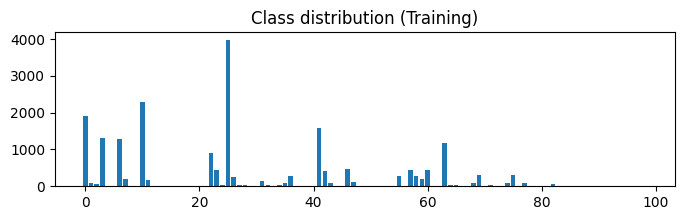

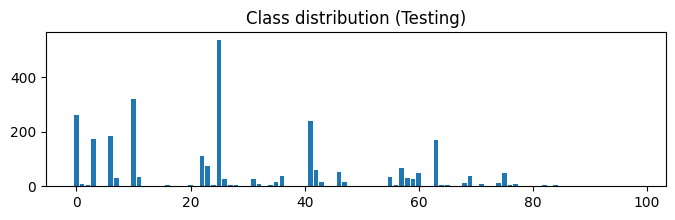

In [44]:
classes, value_counts = np.unique(data.y[data.train_mask].numpy(), return_counts=True)
fig, ax = plt.subplots(figsize=(8, 2))
ax.bar(classes,value_counts)
ax.set_title('Class distribution (Training)')
classes, value_counts = np.unique(data.y[data.test_mask].numpy(), return_counts=True)
fig, ax = plt.subplots(figsize=(8, 2))
ax.bar(classes,value_counts)
ax.set_title('Class distribution (Testing)')